In [23]:
%matplotlib inline

# import PIL
# PIL.PILLOW_VERSION = PIL.__version__

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

rng = np.random.RandomState(1234)
random_state = 42

device = 'cuda'
batch_size = 256

In [24]:
transform = transforms.Compose([       
                                # transforms.Resize((32, 32)),
                                # PyTorchはチャネルなど次元の順番が特殊なので整形する
                                # また、0~255の値を0~1に直してくれる
                                transforms.ToTensor(),
                                # transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                                transforms.Lambda(lambda x: x.view(-1))
])

# データローダーの定義
dataloader_train = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)
dataloader_valid = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
# Prevents NaN by torch.log(0)
def torch_log(x):
  return torch.log(torch.clamp(x, min=1e-10))

In [26]:
labels_size = 10
in_dim = 32*32*3
hid_size = 512
z_dim = 32

class CVAE(nn.Module):
  def __init__(self, z_dim):
    super(CVAE, self).__init__()
    
    self.dense_enc1 = nn.Linear(in_dim + labels_size, 512)
    self.dense_enc2 = nn.Linear(512, 512)
    self.dense_encmean = nn.Linear(512, z_dim)
    self.dense_encvar = nn.Linear(512, z_dim)

    self.dense_dec1 = nn.Linear(z_dim + labels_size, 512)
    self.dense_dec2 = nn.Linear(512, 512)
    self.dense_dec3 = nn.Linear(512, in_dim)

  def _encoder(self, x, labels):
    in_ = torch.cat([x, labels], dim=1)
    x = F.relu(self.dense_enc1(in_))
    x = F.relu(self.dense_enc2(x))
    mean = self.dense_encmean(x)
    std = F.softplus(self.dense_encvar(x))
    return mean, std

  def _sample_z(self, mean, std):
    # Reparametrization
    epsilon = torch.randn_like(mean).to(device)
    return mean + std * epsilon
  
  def _decoder(self, z, labels):
    in_ = torch.cat([z, labels], dim=1)
    y = F.relu(self.dense_dec1(in_))
    y = F.relu(self.dense_dec2(y))
    y = torch.sigmoid(self.dense_dec3(y))
    return y

  def forward(self, x, labels):
    mean, std = self._encoder(x, labels)
    z = self._sample_z(mean, std)
    x = self._decoder(z, labels)
    return x, z

  def loss(self, x, labels):
    mean, std = self._encoder(x, labels)

    KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))

    z = self._sample_z(mean, std)
    y = self._decoder(z, labels)

    reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1-x) * torch_log(1-y), dim=1))

    return KL, -reconstruction

In [27]:
def to_onehot(label):
  return torch.eye(labels_size, device=device, dtype=torch.float32)[label]

In [28]:
n_epochs = 50
model = CVAE(z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(n_epochs):
  losses_train = []
  model.train()
  for x, labels in dataloader_train:

    labels = to_onehot(labels)
    x = x.to(device)

    KL_loss, reconstruction_loss = model.loss(x, labels)
    loss = KL_loss + reconstruction_loss

    model.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.to('cpu').detach().numpy())

  losses_eval = []
  model.eval()
  for x, labels in dataloader_valid:
    labels = to_onehot(labels)
    x = x.to(device)

    KL_loss, reconstruction_loss = model.loss(x, labels)
    loss = KL_loss + reconstruction_loss

    losses_eval.append(loss.to('cpu').detach().numpy())

  print('EPOCH: %d, Train Lower Bound: %lf, Valid Lower Bound: %lf' %
        (epoch+1, np.average(losses_train), np.average(losses_eval)))

EPOCH: 1, Train Lower Bound: 1992.605591, Valid Lower Bound: 1944.213135
EPOCH: 2, Train Lower Bound: 1929.771973, Valid Lower Bound: 1923.171875
EPOCH: 3, Train Lower Bound: 1913.799316, Valid Lower Bound: 1913.208984
EPOCH: 4, Train Lower Bound: 1900.531250, Valid Lower Bound: 1897.440063
EPOCH: 5, Train Lower Bound: 1885.423462, Valid Lower Bound: 1884.817017
EPOCH: 6, Train Lower Bound: 1879.232788, Valid Lower Bound: 1880.930420
EPOCH: 7, Train Lower Bound: 1874.922974, Valid Lower Bound: 1876.480103
EPOCH: 8, Train Lower Bound: 1870.475464, Valid Lower Bound: 1873.046143
EPOCH: 9, Train Lower Bound: 1867.774536, Valid Lower Bound: 1870.654297
EPOCH: 10, Train Lower Bound: 1866.545288, Valid Lower Bound: 1869.622314
EPOCH: 11, Train Lower Bound: 1864.573486, Valid Lower Bound: 1867.126343
EPOCH: 12, Train Lower Bound: 1861.987915, Valid Lower Bound: 1865.631226
EPOCH: 13, Train Lower Bound: 1861.174438, Valid Lower Bound: 1865.304688
EPOCH: 14, Train Lower Bound: 1860.246704, Vali

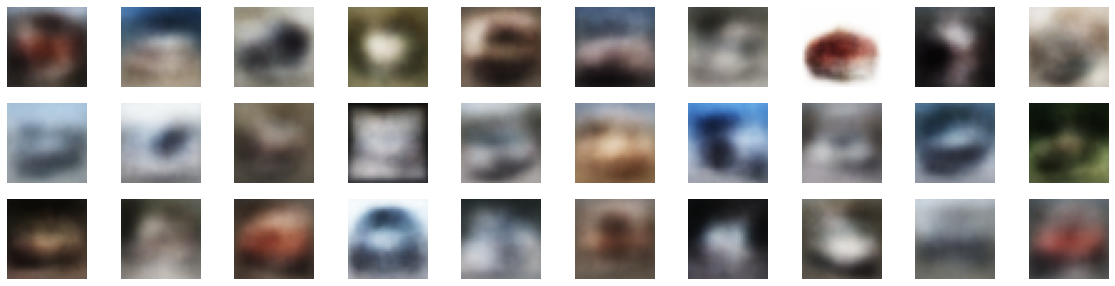

In [40]:
fig, axarr = plt.subplots(3, 10, figsize=(20, 5))

model.eval()
for i, ax in enumerate(axarr.flat):
  z = torch.randn(z_dim, device=device).unsqueeze(dim=0)
  label = torch.tensor([9], device=device)
  with torch.no_grad():
    y = model._decoder(z, to_onehot(label))

  y = y.reshape(3, 32, 32).to('cpu').detach().numpy()
  y = np.transpose(y, (1, 2, 0))

  ax.imshow(y)

  ax.axis("off")